# Assignment: More Xarray with El Niño-Southern Oscillation (ENSO) Data

Here will will calculate the NINO 3.4 index of El Nino variabillity and use it to analyze datasets.

First read [this page from NOAA](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst). It tells you the following:

- The Niño 3.4 region is defined as the region between +/- 5 deg. lat, 170 W - 120 W lon.
- Warm or cold phases of the Oceanic Niño Index are defined by a five consecutive 3-month running mean of sea surface temperature (SST) anomalies in the Niño 3.4 region that is above the threshold of +0.5°C (warm), or below the threshold of -0.5°C (cold). This is known as the Oceanic Niño Index (ONI).

(Note that "anomaly" means that the seasonal cycle, also called the "climatology" has been removed.)

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [33]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### 1. Reproduce the SST curve from the figure below

Use the `sst.mnmean.nc` file that we worked with in class, located at <http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc>.

You don't have to match the stylistic details, or use different colors above and below zero, just the "3mth running mean" curve.

![enso](https://www.ncdc.noaa.gov/monitoring-content/teleconnections/eln-f-pg.gif)

Load the data as an Xarray dataset. Drop the `time_bnds` variable as we did in class and trim the data to 1950 onward for this assignment.

In [34]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables = ['time_bnds'])
ds = ds.sel(time=slice('1950', None))
ds

<xarray.Dataset> Size: 58MB
Dimensions:  (lat: 89, lon: 180, time: 898)
Coordinates:
  * lat      (lat) float32 356B 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 720B 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-10-01
Data variables:
    sst      (time, lat, lon) float32 58MB ...
Attributes: (12/39)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    data_modified:                   2024-11-03
    DODS_EXTRA.Unlimited_Dimension:  time

Now calculate the climatology and the SST anomaly.

In [35]:
nino34 = ds.sel(lat=slice(5, -5), lon = slice(190, 240))
climatology = nino34['sst'].groupby('time.month').mean('time')
sst_anomaly = nino34['sst'].groupby('time.month') - climatology

Now reproduce the plot. Keep the rolling 3-month average of the SST anomaly as a DataArray for the next question.

Text(0, 0.5, 'Temperature [℃]')

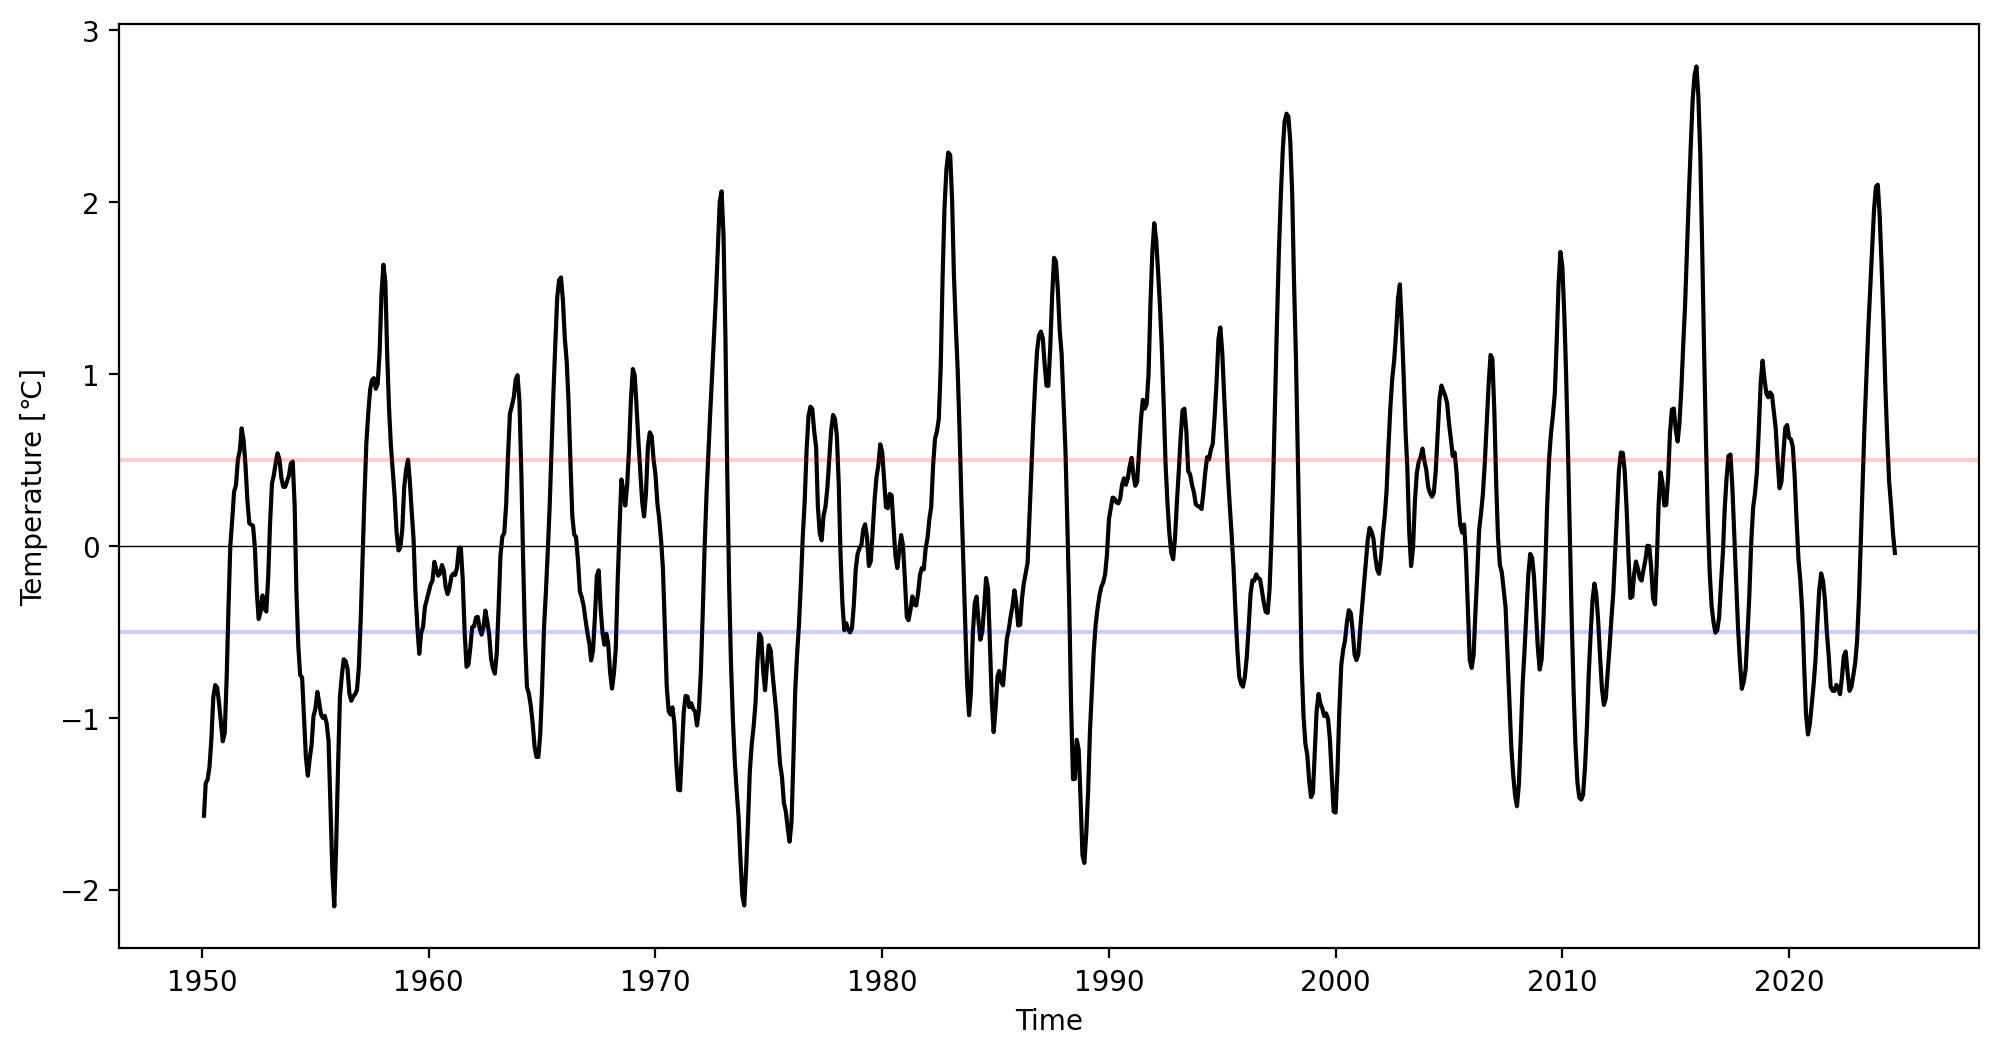

In [36]:
sst_anomaly_mean = sst_anomaly.mean(dim=['lat', 'lon'])

sst_rolling_mean = xr.DataArray(
    sst_anomaly_mean.rolling(time=3, center=True).mean().values,
    coords={'time': sst_anomaly_mean.time},
    dims=['time'],
    name='sst_anomaly_3month_rolling'
    )


plt.plot(sst_rolling_mean.time, sst_rolling_mean, 'k-')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axhline(y=0.5, color='r', alpha = 0.2)
plt.axhline(y=-0.5, color='b', alpha = 0.2)
plt.xlabel('Time')
plt.ylabel('Temperature [℃]')

### 2. Calculate boolean timeseries representing the positive / negative ENSO phases

Refer to the definitions of warm/cold phases above.

In [37]:
warm_threshold = 0.5
cold_threshold = -0.5

enso_phase = xr.DataArray(
    sst_rolling_mean.values,
    coords={'time': sst_rolling_mean.time},
    dims=['time'],
    name='enso_phase'
)

enso_phase = xr.where(sst_rolling_mean >= warm_threshold, 1, xr.where(sst_rolling_mean <= cold_threshold, -1, 0))

Plot them somehow.

/tmp/ipykernel_997/3447177886.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Temperature [℃]')

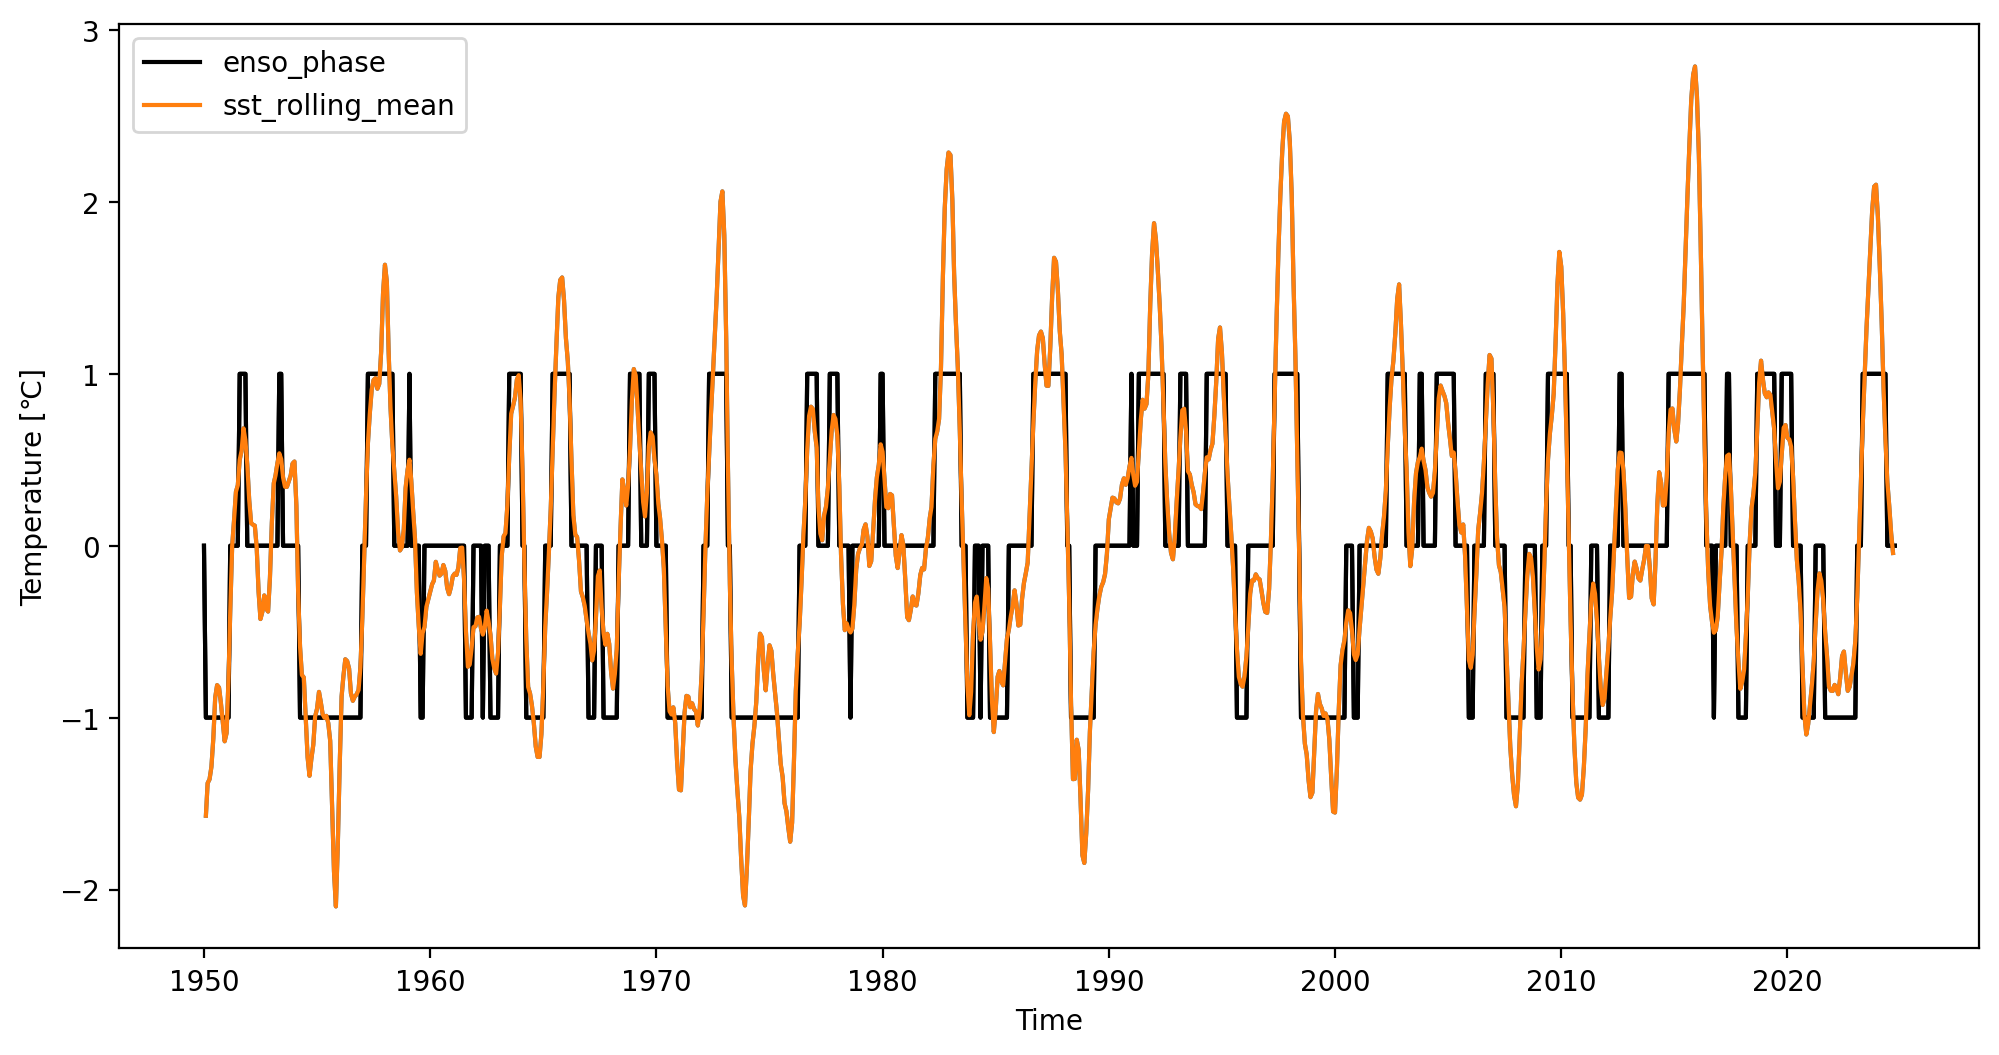

In [40]:
plt.plot(enso_phase.time, enso_phase, 'k')
plt.plot(sst_rolling_mean.time, sst_rolling_mean)

plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature [℃]')

plt.plot(enso_phase.time, enso_phase, 'k', label='enso_phase')
plt.plot(sst_rolling_mean.time, sst_rolling_mean, label='sst_rolling_mean')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Temperature [℃]')

### 3. Plot composites of SST anomaly for the positive and negative ENSO regimes

These should be pcolormesh maps. First positive ONI.

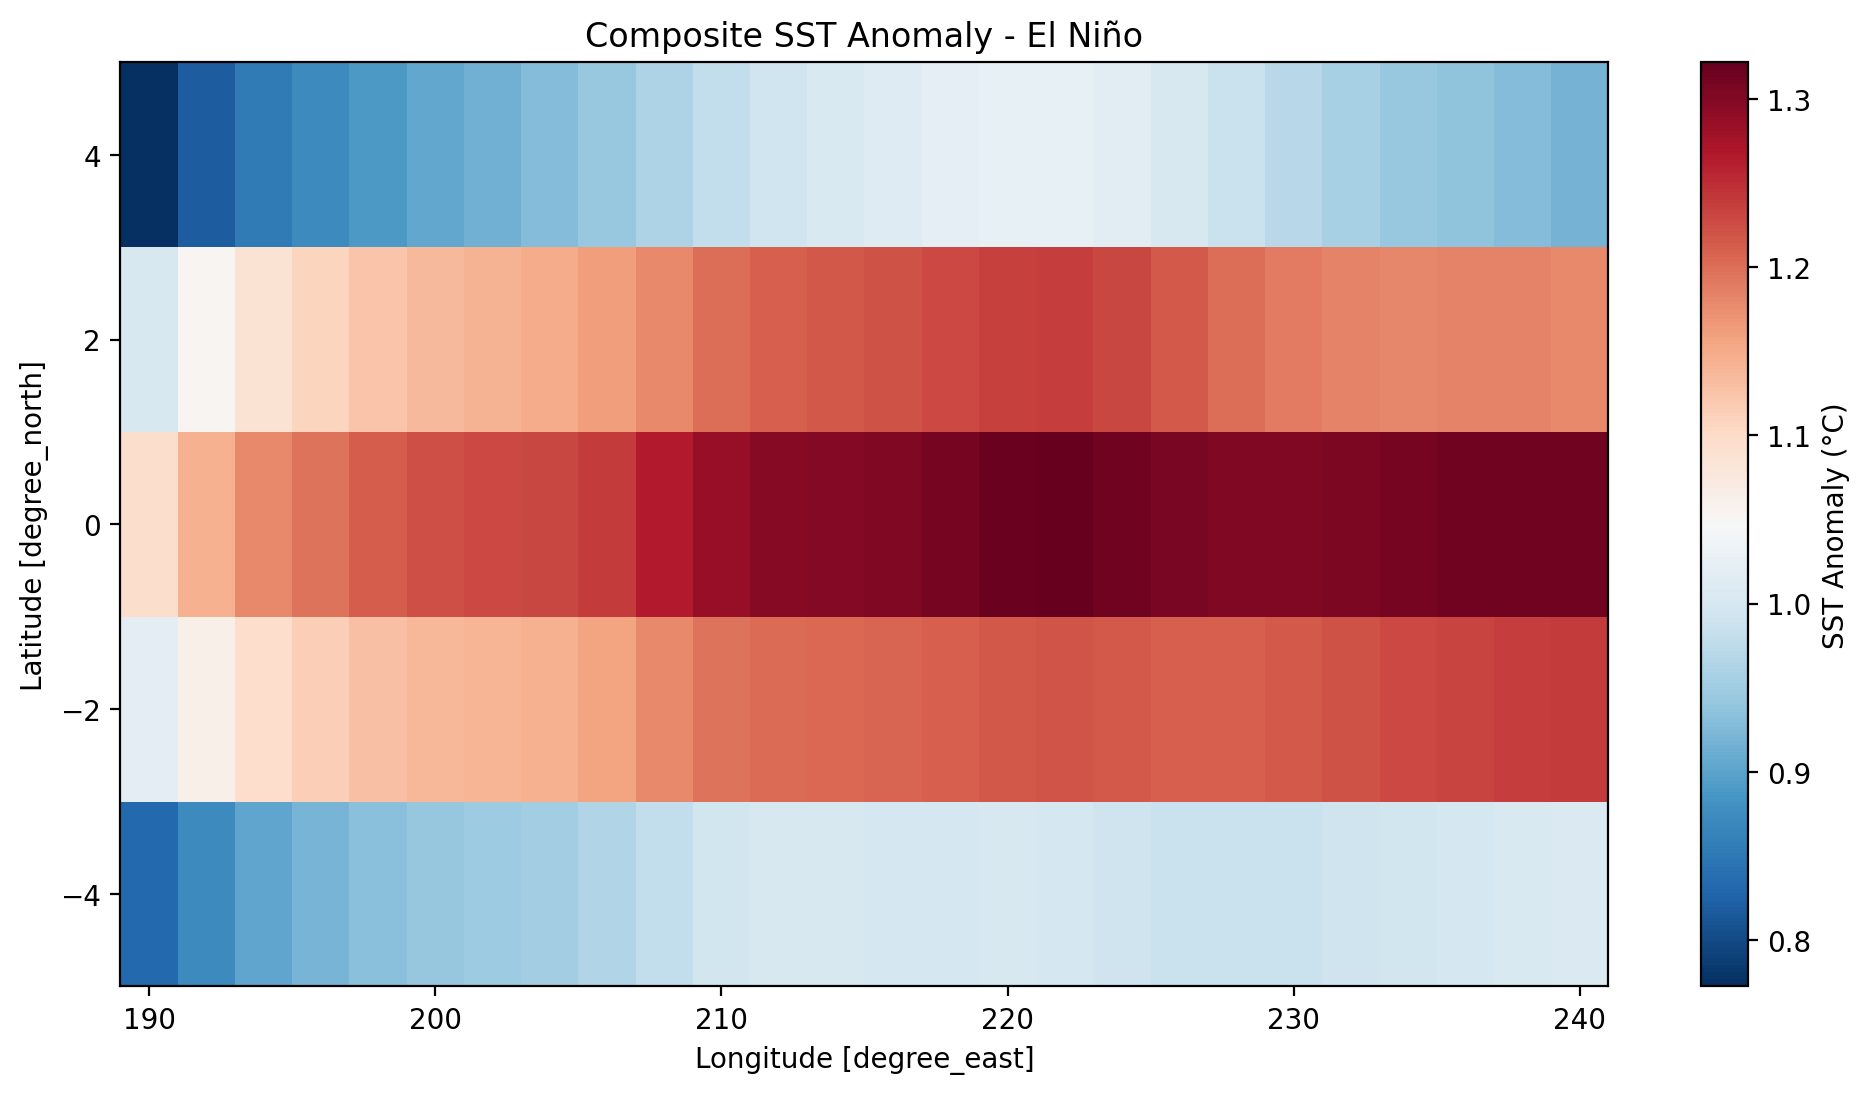

In [30]:
el_nino_sst = sst_anomaly.sel(time=enso_phase == 1).mean(dim='time')

fig, ax1 = plt.subplots()

positive = ax1.pcolormesh(el_nino_sst.lon, el_nino_sst.lat, el_nino_sst, cmap='RdBu_r', shading='auto')
ax1.set_title('Composite SST Anomaly - El Niño')
ax1.set_xlabel('Longitude [degree_east]')
ax1.set_ylabel('Latitude [degree_north]')
plt.colorbar(positive, ax=ax1, orientation='vertical', label='SST Anomaly (°C)')

And negative ONI.

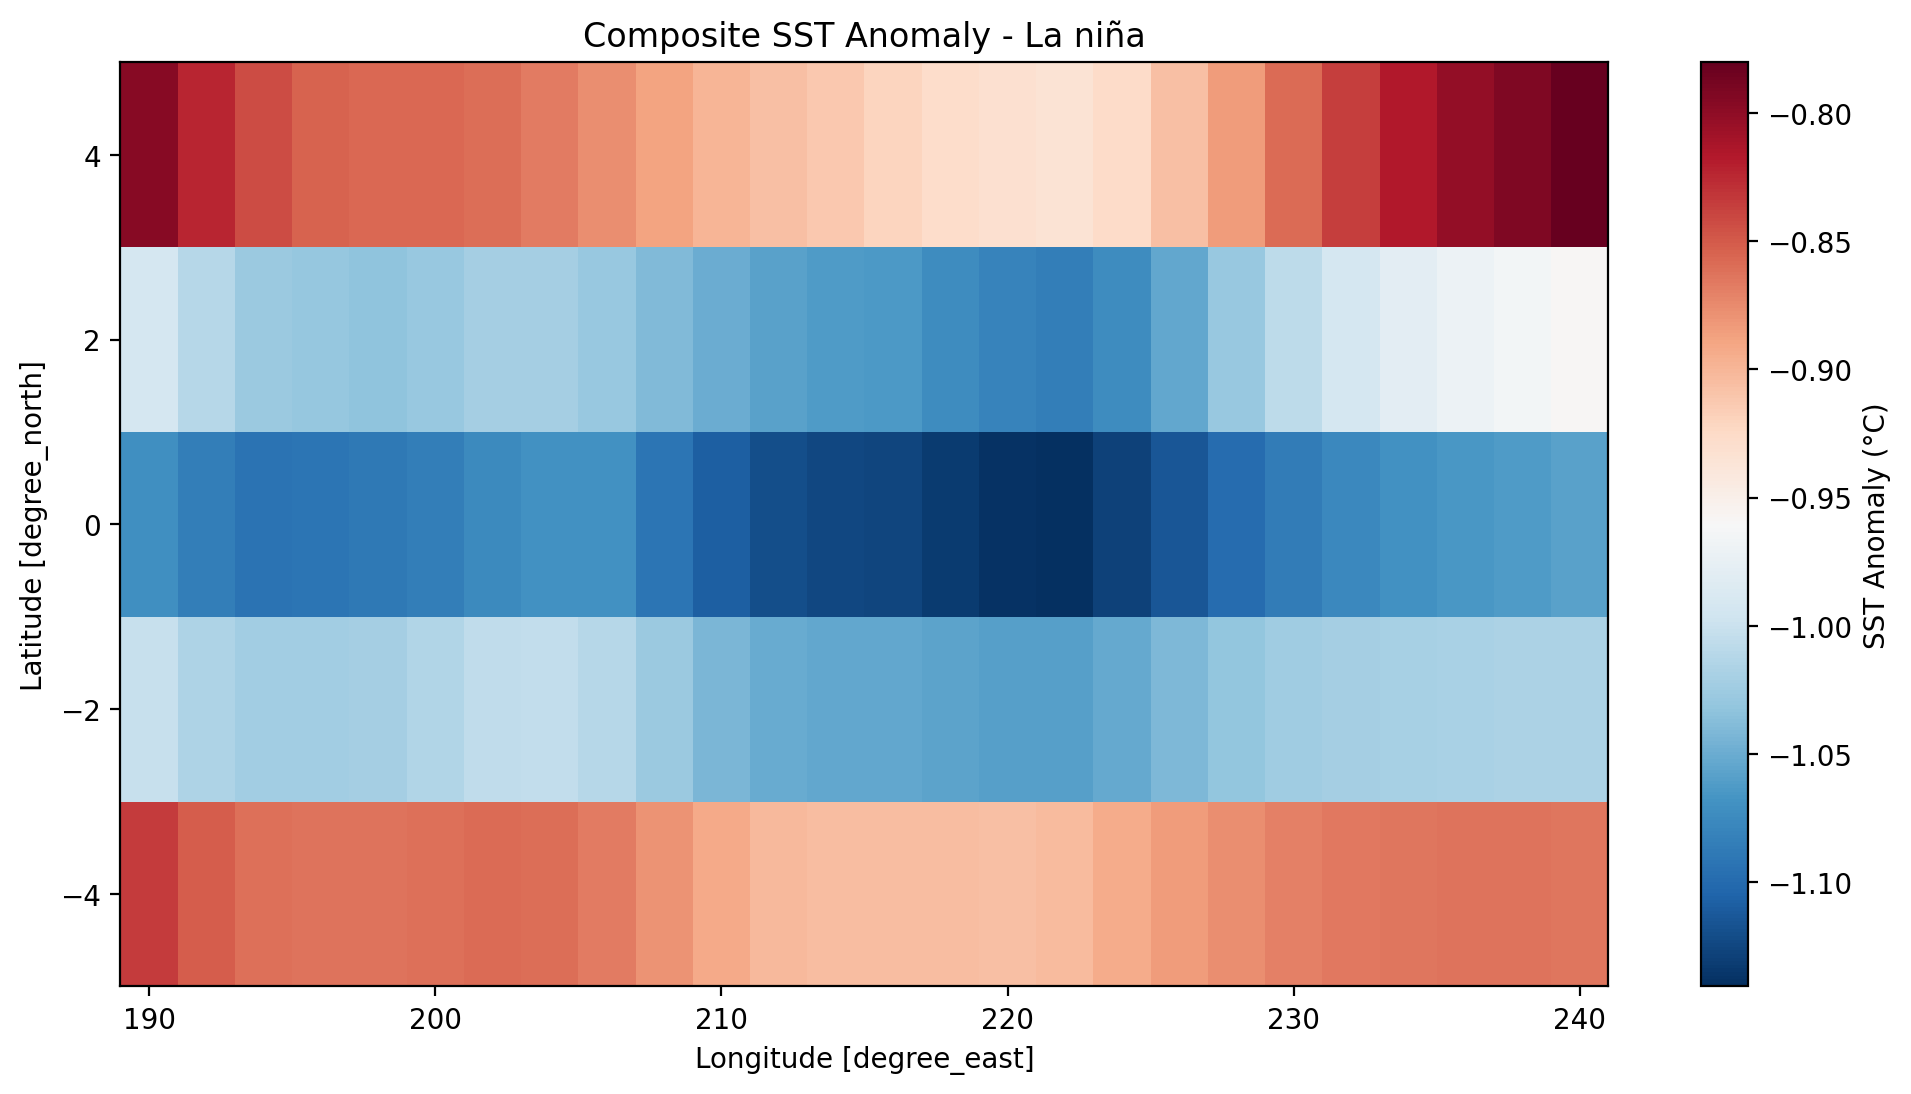

In [29]:
fig, ax2 = plt.subplots()
la_nina_sst = sst_anomaly.sel(time=enso_phase == -1).mean(dim='time')

negative = ax2.pcolormesh(la_nina_sst.lon, la_nina_sst.lat, la_nina_sst, cmap='RdBu_r', shading='auto')
ax2.set_title('Composite SST Anomaly - La niña')
ax2.set_xlabel('Longitude [degree_east]')
ax2.set_ylabel('Latitude [degree_north]')
plt.colorbar(negative, ax=ax2, orientation='vertical', label='SST Anomaly (°C)')

### 4. Calculate the composite of preciptiation for positive and negative ENSO phases.

First load the precip dataset. Code to fix the broken time coordinate is included.

In [20]:
import pandas as pd
import xarray as xr
url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NASA/.GPCP/.V2p1/.multi-satellite/.prcp/dods'
dsp = xr.open_dataset(url, decode_times=False)
true_time = (pd.date_range(start='1960-01-01', periods=len(dsp['T']), freq='MS'))
dsp['T'] = true_time
dsp = dsp.rename({'T': 'time'})
dsp.load()

<xarray.Dataset> Size: 15MB
Dimensions:  (X: 144, time: 361, Y: 72)
Coordinates:
  * X        (X) float32 576B 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 3kB 1960-01-01 1960-02-01 ... 1990-01-01
  * Y        (Y) float32 288B 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
Data variables:
    prcp     (time, Y, X) float32 15MB nan nan nan ... 0.07234 0.06634 0.06526
Attributes:
    Conventions:  IRIDL

Now plot the *difference* between the time-mean of `prcp` during positive and negative ENSO phases.

Text(0.5, 1.0, 'Difference between Precipitation during Positive and Negative ENSO phases')

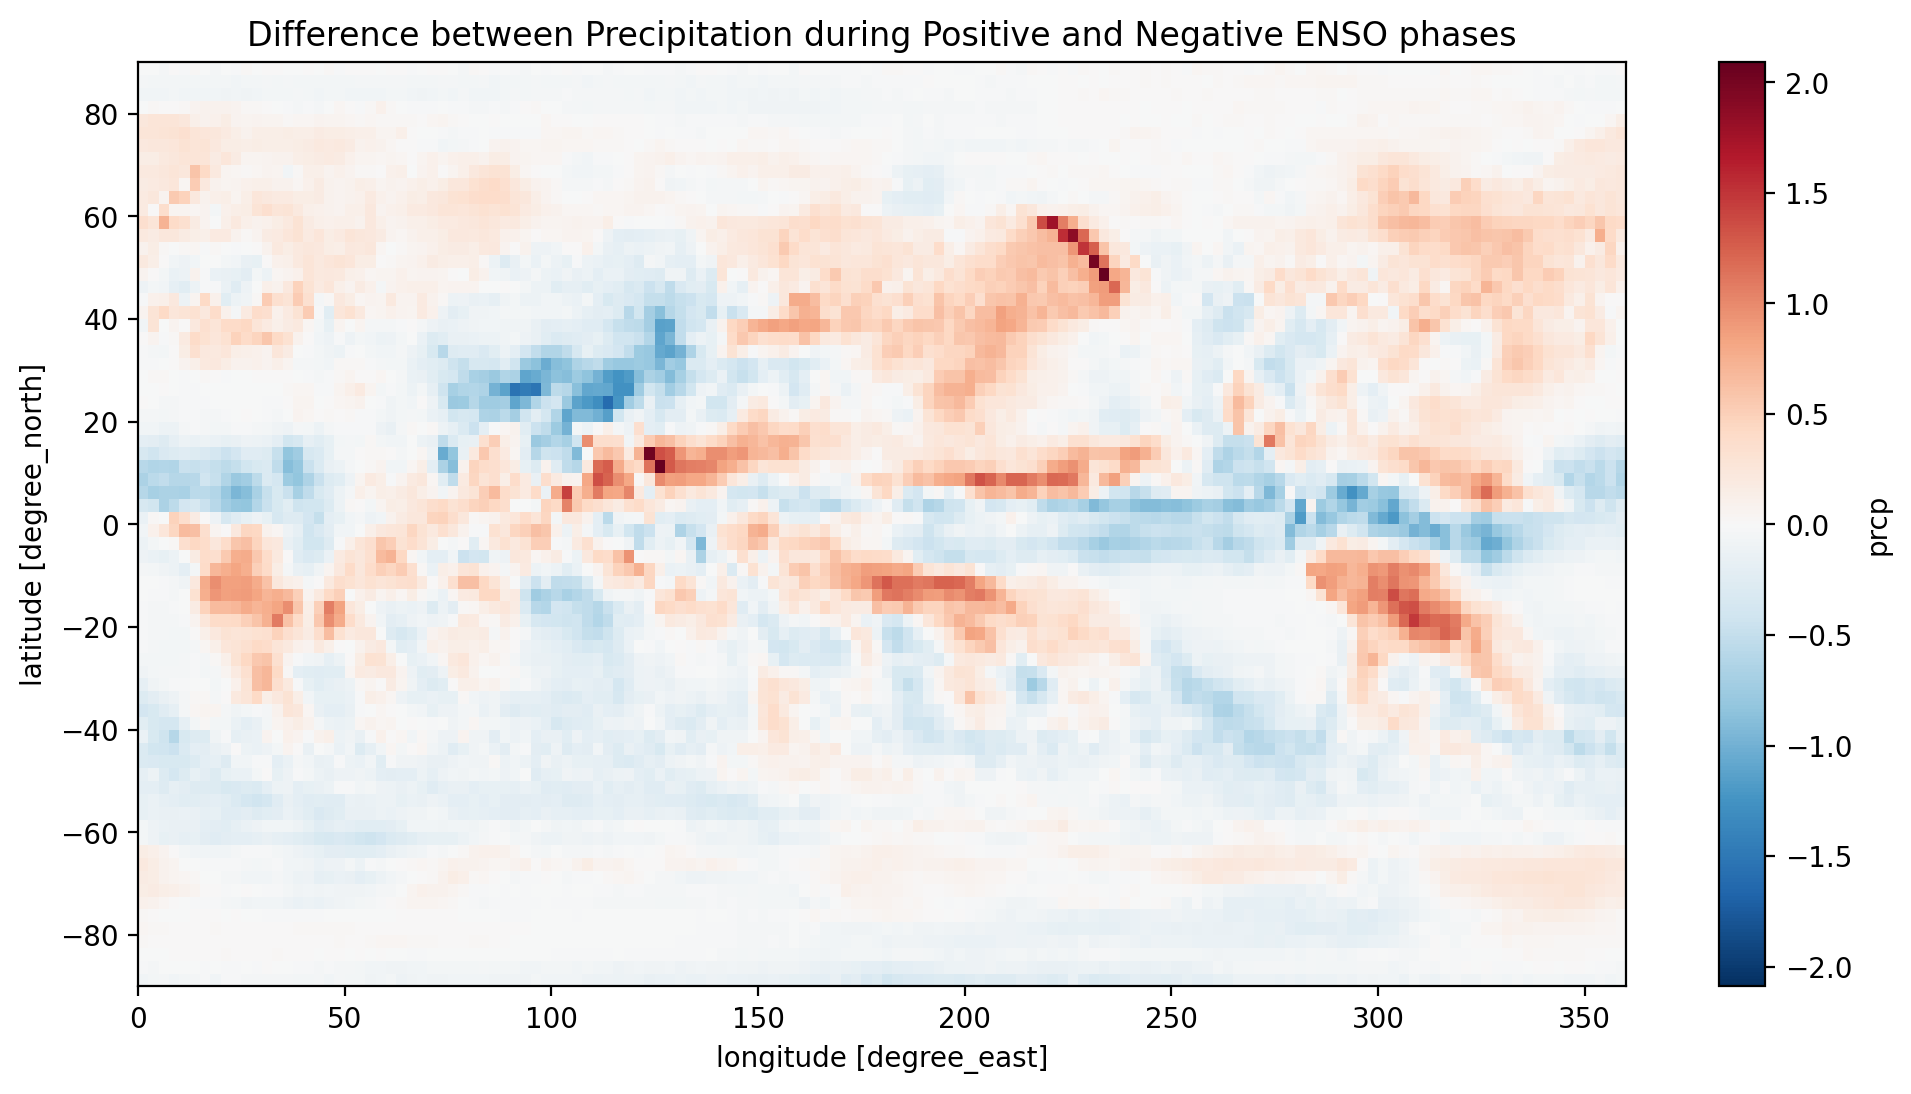

In [32]:
pos_mean = dsp.prcp.where(sst_rolling_mean >= warm_threshold).mean('time')
neg_mean = dsp.prcp.where(sst_rolling_mean <= warm_threshold).mean('time')

diff_mean = pos_mean - neg_mean

diff_mean.plot()
plt.title('Difference between Precipitation during Positive and Negative ENSO phases')